<a href="https://colab.research.google.com/github/HaardhikK/Arthantar/blob/main/test/Test_Combining_Coreference_and_Knowledge_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gender as well in transformer KG

In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json
import spacy
from collections import defaultdict

class KnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "Gemma2-9b-It"):
        """Initialize the knowledge graph generator with Groq API"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)
        # Load spaCy model
        self.nlp = spacy.load("en_core_web_sm")

    def _identify_gender(self, text: str) -> Dict[str, str]:
        """
        Identify gender of entities based on pronoun usage and context
        Returns a dictionary mapping entity names to their identified gender
        """
        doc = self.nlp(text)

        # Initialize gender tracking
        gender_map = {}
        current_entity = None

        # Track pronouns associated with each entity
        entity_pronouns = defaultdict(list)

        # First pass: Collect named entities
        entities = {ent.text: None for ent in doc.ents if ent.label_ == "PERSON"}

        # Process the text to track pronouns and their associations
        for token in doc:
            # If we find a person's name, set it as current entity
            if token.text in entities:
                current_entity = token.text

            # Track pronouns associated with current entity
            if current_entity and token.tag_ in ['PRP', 'PRP$']:  # Personal pronouns
                entity_pronouns[current_entity].append(token.text.lower())

            # Basic pronoun gender mapping
            if token.tag_ in ['PRP', 'PRP$']:
                pronoun = token.text.lower()
                if pronoun in ['he', 'his', 'him', 'himself']:
                    if current_entity:
                        gender_map[current_entity] = 'male'
                elif pronoun in ['she', 'her', 'hers', 'herself']:
                    if current_entity:
                        gender_map[current_entity] = 'female'

        return gender_map

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text"""
        try:
            # Identify gender information
            gender_info = self._identify_gender(text)

            # Add minimum context for very short texts
            if len(text.split()) < 30:
                text = "Please analyze this short text and extract all possible relationships: " + text

            # Convert text to document format
            documents = [Document(page_content=text)]

            # Generate graph documents using LLM
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            # Debug print to identify the graph source
            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                print("Using Basic Graph Generation.")
                return self._create_basic_graph(text, gender_info)
            else:
                print("Using LLM-based Graph Generation.")

            # Extract nodes and relationships
            nodes = graph_documents[0].nodes if graph_documents[0].nodes else []
            relationships = graph_documents[0].relationships if graph_documents[0].relationships else []

            # Create NetworkX graph
            G = nx.DiGraph()

            # Add nodes to the graph with gender information
            for node in nodes:
                properties = node.properties or {}
                if node.id in gender_info:
                    properties['gender'] = gender_info[node.id]
                G.add_node(node.id, type=node.type, properties=properties)

            # Add edges (relationships) to the graph
            for rel in relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            # If graph is empty, fallback to basic graph
            if len(G.nodes()) == 0:
                print("LLM generated empty graph; switching to Basic Graph Generation.")
                return self._create_basic_graph(text, gender_info)

            return {
                'nodes': [{'id': n,
                          'type': G.nodes[n]['type'],
                          'properties': G.nodes[n]['properties']} for n in G.nodes()],
                'relationships': [{'source': u,
                                 'target': v,
                                 'type': G.edges[u, v]['type']}
                                for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            print("Switching to Basic Graph Generation due to an error.")
            return self._create_basic_graph(text, gender_info)

    def _create_basic_graph(self, text: str, gender_info: Dict[str, str]) -> Dict:
        """Create a basic graph structure for cases where the LLM fails"""
        # Split the text into sentences
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()
        relationships = []

        # Extract basic entities (nouns) and relationships
        for sentence in sentences:
            words = sentence.split()
            # Add capitalized words as potential entities
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes with gender information
        for entity in entities:
            properties = {}
            if entity in gender_info:
                properties['gender'] = gender_info[entity]
            G.add_node(entity, type='Entity', properties=properties)

        # Add basic relationships between consecutive entities
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{'id': n,
                      'type': 'Entity',
                      'properties': G.nodes[n]['properties']} for n in G.nodes()],
            'relationships': [{'source': u,
                             'target': v,
                             'type': G.edges[u, v]['type']}
                            for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("Knowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            gender = node.get('properties', {}).get('gender', 'unknown')
            print(f"- {node['id']} (Type: {node['type']}, Gender: {gender})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    # Sample text
    sample_text = "Kiran is a good student in a school and Sita is his teacher. She teaches science."

    # Create graph generator instance
    kg_generator = KnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Using LLM-based Graph Generation.
Knowledge Graph Structure:

Nodes:
- Kiran (Type: Person, Gender: female)
- Sita (Type: Person, Gender: unknown)
- School (Type: School, Gender: unknown)
- Science (Type: Subject, Gender: unknown)

Relationships:
- Kiran --[ATTENDS]--> School
- Kiran --[TEACHER]--> Sita
- Sita --[TEACHES]--> Science


#Gender 2

In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json
from fastcoref import FCoref

class EnhancedKnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "Gemma2-9b-It"):
        """Initialize the knowledge graph generator with Groq API and coref model"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)
        self.coref_model = FCoref()

    def identify_genders_coref(self, text: str) -> Dict[str, str]:
        """Identify genders using coreference resolution"""
        gender_map = {}
        try:
            # Get coreference clusters
            preds = self.coref_model.predict(texts=[text])
            clusters = preds[0].get_clusters()
            # Print coreference clusters for debugging
            print("Coreference Clusters:")
            for cluster in clusters:
               print(f"Cluster: {cluster}")

            for cluster in clusters:
                # Check for gender-indicating pronouns in the cluster
                has_he = any(pronoun.lower() == 'he' for pronoun in cluster)
                has_she = any(pronoun.lower() == 'she' for pronoun in cluster)

                if has_he or has_she:
                    # Assign gender to all entities in the cluster
                    gender = 'male' if has_he else 'female'
                    for entity in cluster:
                        if entity.lower() not in ['he', 'she', 'him', 'her']:
                            gender_map[entity] = gender

        except Exception as e:
            print(f"Coreference resolution error: {str(e)}")

        return gender_map

    def identify_gender_llm(self, entity: str, entity_type: str) -> str:
        """Use LLM to identify gender when coref fails"""
        try:
            prompt = f"""
            Analyze the entity name '{entity}' with type '{entity_type}'.
            If it's a person, determine their likely gender based on context.
            Respond with exactly one word: 'male', 'female', or 'unknown'.
            For non-person entities, always respond with 'unknown'.
            """

            response = self.llm.predict(prompt)
            gender = response.lower().strip()

            if gender not in ['male', 'female', 'unknown']:
                return 'unknown'

            return gender

        except Exception as e:
            print(f"LLM gender identification error for {entity}: {str(e)}")
            return 'unknown'

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text with gender information"""
        try:
            # First pass: Get gender information from coreference resolution
            gender_map = self.identify_genders_coref(text)

            # Generate base graph
            documents = [Document(page_content=text)]
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                print("Using Basic Graph Generation.")
                return self._create_basic_graph(text, gender_map)

            print("Using LLM-based Graph Generation.")

            # Create NetworkX graph with gender information
            G = nx.DiGraph()

            # Add nodes with gender information
            for node in graph_documents[0].nodes:
                # Get gender from coref map or use LLM as backup
                gender = gender_map.get(node.id, None)
                if gender is None:
                    gender = self.identify_gender_llm(node.id, node.type)

                G.add_node(node.id,
                          type=node.type,
                          gender=gender,
                          properties=node.properties)

            # Add relationships
            for rel in graph_documents[0].relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            return {
                'nodes': [{
                    'id': n,
                    'type': G.nodes[n]['type'],
                    'gender': G.nodes[n]['gender']
                } for n in G.nodes()],
                'relationships': [{
                    'source': u,
                    'target': v,
                    'type': G.edges[u, v]['type']
                } for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text, gender_map)

    def _create_basic_graph(self, text: str, gender_map: Dict[str, str]) -> Dict:
        """Create a basic graph structure with gender information"""
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()

        # Extract basic entities
        for sentence in sentences:
            words = sentence.split()
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes with gender information
        for entity in entities:
            gender = gender_map.get(entity, None)
            if gender is None:
                gender = self.identify_gender_llm(entity, 'Entity')

            G.add_node(entity, type='Entity', gender=gender)

        # Add basic relationships
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{
                'id': n,
                'type': 'Entity',
                'gender': G.nodes[n]['gender']
            } for n in G.nodes()],
            'relationships': [{
                'source': u,
                'target': v,
                'type': G.edges[u, v]['type']
            } for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("Knowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']}, Gender: {node['gender']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    sample_text = "Kiran is a good student, and Sita is his science teacher, and he teaches him science."

    # Create graph generator instance
    kg_generator = EnhancedKnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coreference Clusters:
Cluster: ['Kiran', 'his', 'him']
Cluster: ['Sita', 'he']
Using LLM-based Graph Generation.
Knowledge Graph Structure:

Nodes:
- Kiran (Type: Person, Gender: unknown)
- Sita (Type: Person, Gender: male)

Relationships:
- Kiran --[TEACHER]--> Sita


In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json
from fastcoref import FCoref

class EnhancedKnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "Gemma2-9b-It"):
        """Initialize the knowledge graph generator with Groq API and coref model"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)
        self.coref_model = FCoref()

    def identify_genders_coref(self, text: str) -> Dict[str, str]:
        """Identify genders using coreference resolution"""
        gender_map = {}
        try:
            # Get coreference clusters
            preds = self.coref_model.predict(texts=[text])
            clusters = preds[0].get_clusters()

            print("Coreference Clusters:")
            for cluster in clusters:
                print(f"Cluster: {cluster}")

                # Create sets for male and female indicating pronouns
                male_pronouns = {'he', 'him', 'his'}
                female_pronouns = {'she', 'her', 'hers'}

                # Check pronouns in the cluster
                cluster_pronouns = {word.lower() for word in cluster}
                has_male = bool(cluster_pronouns & male_pronouns)
                has_female = bool(cluster_pronouns & female_pronouns)

                # Determine gender based on pronouns
                if has_male and not has_female:
                    gender = 'male'
                elif has_female and not has_male:
                    gender = 'female'
                else:
                    continue  # Skip if no clear gender indicators

                # Assign gender to all non-pronoun entities in the cluster
                for entity in cluster:
                    if (entity.lower() not in male_pronouns and
                        entity.lower() not in female_pronouns and
                        entity[0].isupper()):  # Only proper nouns
                        gender_map[entity] = gender
                        print(f"Assigned {gender} to {entity} based on pronouns")

        except Exception as e:
            print(f"Coreference resolution error: {str(e)}")

        return gender_map

    def identify_gender_llm(self, entity: str, entity_type: str, gender_map: Dict[str, str]) -> str:
        """Use LLM to identify gender when coref fails"""
        # First check if we already have gender from coref
        if entity in gender_map:
            return gender_map[entity]

        if entity_type.lower() != 'person':
            return 'unknown'

        try:
            prompt = f"""
            Analyze the entity name '{entity}' with type '{entity_type}'.
            If it's a person, determine their likely gender based on context.
            Respond with exactly one word: 'male', 'female', or 'unknown'.
            For non-person entities, always respond with 'unknown'.
            """

            response = self.llm.predict(prompt)
            gender = response.lower().strip()

            if gender not in ['male', 'female', 'unknown']:
                return 'unknown'

            return gender

        except Exception as e:
            print(f"LLM gender identification error for {entity}: {str(e)}")
            return 'unknown'

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text with gender information"""
        try:
            # First pass: Get gender information from coreference resolution
            gender_map = self.identify_genders_coref(text)
            print(f"\nIdentified genders from coref: {gender_map}")

            # Generate base graph
            documents = [Document(page_content=text)]
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                print("Using Basic Graph Generation.")
                return self._create_basic_graph(text, gender_map)

            print("Using LLM-based Graph Generation.")

            # Create NetworkX graph with gender information
            G = nx.DiGraph()

            # Add nodes with gender information
            for node in graph_documents[0].nodes:
                # Use gender from coref map first, then fallback to LLM
                gender = self.identify_gender_llm(node.id, node.type, gender_map)

                G.add_node(node.id,
                          type=node.type,
                          gender=gender,
                          properties=node.properties)

            # Add relationships
            for rel in graph_documents[0].relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            return {
                'nodes': [{
                    'id': n,
                    'type': G.nodes[n]['type'],
                    'gender': G.nodes[n]['gender']
                } for n in G.nodes()],
                'relationships': [{
                    'source': u,
                    'target': v,
                    'type': G.edges[u, v]['type']
                } for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text, gender_map)

    def _create_basic_graph(self, text: str, gender_map: Dict[str, str]) -> Dict:
        """Create a basic graph structure with gender information"""
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()

        # Extract basic entities
        for sentence in sentences:
            words = sentence.split()
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes with gender information
        for entity in entities:
            gender = self.identify_gender_llm(entity, 'Entity', gender_map)
            G.add_node(entity, type='Entity', gender=gender)

        # Add basic relationships
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{
                'id': n,
                'type': 'Entity',
                'gender': G.nodes[n]['gender']
            } for n in G.nodes()],
            'relationships': [{
                'source': u,
                'target': v,
                'type': G.edges[u, v]['type']
            } for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("\nKnowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']}, Gender: {node['gender']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    sample_text = "Kiran is a good student, and Sita is his science teacher, and he teaches him science."

    # Create graph generator instance
    kg_generator = EnhancedKnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coreference Clusters:
Cluster: ['Kiran', 'his', 'him']
Assigned male to Kiran based on pronouns
Cluster: ['Sita', 'he']
Assigned male to Sita based on pronouns

Identified genders from coref: {'Kiran': 'male', 'Sita': 'male'}
Using LLM-based Graph Generation.

Knowledge Graph Structure:

Nodes:
- Kiran (Type: Person, Gender: male)
- Sita (Type: Person, Gender: male)

Relationships:
- Kiran --[TEACHER]--> Sita


In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json
from fastcoref import FCoref

class EnhancedKnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "Gemma2-9b-It"):
        """Initialize the knowledge graph generator with Groq API and coref model"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)
        self.coref_model = FCoref()

    def identify_genders_coref(self, text: str) -> Dict[str, str]:
        """Identify genders using coreference resolution"""
        gender_map = {}
        try:
            # Get coreference clusters
            preds = self.coref_model.predict(texts=[text])
            clusters = preds[0].get_clusters()

            print("Coreference Clusters:")
            for cluster in clusters:
                print(f"Cluster: {cluster}")

                # Create sets for male and female indicating pronouns
                male_pronouns = {'he', 'him', 'his'}
                female_pronouns = {'she', 'her', 'hers'}

                # Check pronouns in the cluster
                cluster_pronouns = {word.lower() for word in cluster}
                has_male = bool(cluster_pronouns & male_pronouns)
                has_female = bool(cluster_pronouns & female_pronouns)

                # Determine gender based on pronouns
                if has_male and not has_female:
                    gender = 'male'
                elif has_female and not has_male:
                    gender = 'female'
                else:
                    continue  # Skip if no clear gender indicators

                # Assign gender to all non-pronoun entities in the cluster
                for entity in cluster:
                    if (entity.lower() not in male_pronouns and
                        entity.lower() not in female_pronouns and
                        entity[0].isupper()):  # Only proper nouns
                        gender_map[entity] = gender
                        print(f"Assigned {gender} to {entity} based on pronouns")

        except Exception as e:
            print(f"Coreference resolution error: {str(e)}")

        return gender_map

    def identify_gender_llm(self, entity: str, entity_type: str, gender_map: Dict[str, str]) -> str:
        """Use LLM to identify gender when coref fails"""
        # First check if we already have gender from coref
        if entity in gender_map:
            return gender_map[entity]

        if entity_type.lower() != 'person':
            return 'unknown'

        try:
            prompt = f"""
            Analyze the entity name '{entity}' with type '{entity_type}'.
            If it's a person, determine their likely gender based on context.
            Respond with exactly one word: 'male', 'female', or 'unknown'.
            For non-person entities, always respond with 'unknown'.
            """

            response = self.llm.predict(prompt)
            gender = response.lower().strip()

            if gender not in ['male', 'female', 'unknown']:
                return 'unknown'

            return gender

        except Exception as e:
            print(f"LLM gender identification error for {entity}: {str(e)}")
            return 'unknown'

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text with gender information"""
        try:
            # First pass: Get gender information from coreference resolution
            gender_map = self.identify_genders_coref(text)
            print(f"\nIdentified genders from coref: {gender_map}")

            # Generate base graph
            documents = [Document(page_content=text)]
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                print("Using Basic Graph Generation.")
                return self._create_basic_graph(text, gender_map)

            print("Using LLM-based Graph Generation.")

            # Create NetworkX graph with gender information
            G = nx.DiGraph()

            # Add nodes with gender information
            for node in graph_documents[0].nodes:
                # Use gender from coref map first, then fallback to LLM
                gender = self.identify_gender_llm(node.id, node.type, gender_map)

                G.add_node(node.id,
                          type=node.type,
                          gender=gender,
                          properties=node.properties)

            # Add relationships
            for rel in graph_documents[0].relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            return {
                'nodes': [{
                    'id': n,
                    'type': G.nodes[n]['type'],
                    'gender': G.nodes[n]['gender']
                } for n in G.nodes()],
                'relationships': [{
                    'source': u,
                    'target': v,
                    'type': G.edges[u, v]['type']
                } for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text, gender_map)

    def _create_basic_graph(self, text: str, gender_map: Dict[str, str]) -> Dict:
        """Create a basic graph structure with gender information"""
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()

        # Extract basic entities
        for sentence in sentences:
            words = sentence.split()
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes with gender information
        for entity in entities:
            gender = self.identify_gender_llm(entity, 'Entity', gender_map)
            G.add_node(entity, type='Entity', gender=gender)

        # Add basic relationships
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{
                'id': n,
                'type': 'Entity',
                'gender': G.nodes[n]['gender']
            } for n in G.nodes()],
            'relationships': [{
                'source': u,
                'target': v,
                'type': G.edges[u, v]['type']
            } for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("\nKnowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']}, Gender: {node['gender']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    sample_text = "Kiran is a good student, he goes to school regularly. Diana is his teacher and she teaches maths."

    # Create graph generator instance
    kg_generator = EnhancedKnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coreference Clusters:
Cluster: ['Kiran', 'he', 'his']
Assigned male to Kiran based on pronouns
Cluster: ['Diana', 'she']
Assigned female to Diana based on pronouns

Identified genders from coref: {'Kiran': 'male', 'Diana': 'female'}
Using LLM-based Graph Generation.

Knowledge Graph Structure:

Nodes:
- Kiran (Type: Person, Gender: male)
- Diana (Type: Person, Gender: female)

Relationships:
- Kiran --[STUDENT_TEACHER]--> Diana


#Best model for now

In [ ]:
# best example
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json
from fastcoref import FCoref

class EnhancedKnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "Gemma2-9b-It"):
        """Initialize the knowledge graph generator with Groq API and coref model"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)
        self.coref_model = FCoref()

    def identify_genders_coref(self, text: str) -> Dict[str, str]:
        """Identify genders using coreference resolution"""
        gender_map = {}
        try:
            # Get coreference clusters
            preds = self.coref_model.predict(texts=[text])
            clusters = preds[0].get_clusters()

            print("Coreference Clusters:")
            for cluster in clusters:
                print(f"Cluster: {cluster}")

                # Create sets for male and female indicating pronouns
                male_pronouns = {'he', 'him', 'his'}
                female_pronouns = {'she', 'her', 'hers'}

                # Check pronouns in the cluster
                cluster_pronouns = {word.lower() for word in cluster}
                has_male = bool(cluster_pronouns & male_pronouns)
                has_female = bool(cluster_pronouns & female_pronouns)

                # Determine gender based on pronouns
                if has_male and not has_female:
                    gender = 'male'
                elif has_female and not has_male:
                    gender = 'female'
                else:
                    continue  # Skip if no clear gender indicators

                # Assign gender to all non-pronoun entities in the cluster
                for entity in cluster:
                    if (entity.lower() not in male_pronouns and
                        entity.lower() not in female_pronouns and
                        entity[0].isupper()):  # Only proper nouns
                        gender_map[entity] = gender
                        print(f"Assigned {gender} to {entity} based on pronouns")

        except Exception as e:
            print(f"Coreference resolution error: {str(e)}")

        return gender_map

    def identify_gender_llm(self, entity: str, entity_type: str, gender_map: Dict[str, str]) -> str:
        """Use LLM to identify gender when coref fails"""
        # First check if we already have gender from coref
        if entity in gender_map:
            return gender_map[entity]

        if entity_type.lower() != 'person':
            return 'unknown'

        try:
            prompt = f"""
            Analyze the entity name '{entity}' with type '{entity_type}'.
            If it's a person, determine their likely gender based on context.
            Respond with exactly one word: 'male', 'female', or 'unknown'.
            For non-person entities, always respond with 'unknown'.
            """

            response = self.llm.predict(prompt)
            gender = response.lower().strip()

            if gender not in ['male', 'female', 'unknown']:
                return 'unknown'

            return gender

        except Exception as e:
            print(f"LLM gender identification error for {entity}: {str(e)}")
            return 'unknown'

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text with gender information"""
        try:
            # First pass: Get gender information from coreference resolution
            gender_map = self.identify_genders_coref(text)
            print(f"\nIdentified genders from coref: {gender_map}")

            # Generate base graph
            documents = [Document(page_content=text)]
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                print("Using Basic Graph Generation.")
                return self._create_basic_graph(text, gender_map)

            print("Using LLM-based Graph Generation.")

            # Create NetworkX graph with gender information
            G = nx.DiGraph()

            # Add nodes with gender information
            for node in graph_documents[0].nodes:
                # Use gender from coref map first, then fallback to LLM
                gender = self.identify_gender_llm(node.id, node.type, gender_map)

                G.add_node(node.id,
                          type=node.type,
                          gender=gender,
                          properties=node.properties)

            # Add relationships
            for rel in graph_documents[0].relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            return {
                'nodes': [{
                    'id': n,
                    'type': G.nodes[n]['type'],
                    'gender': G.nodes[n]['gender']
                } for n in G.nodes()],
                'relationships': [{
                    'source': u,
                    'target': v,
                    'type': G.edges[u, v]['type']
                } for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text, gender_map)

    def _create_basic_graph(self, text: str, gender_map: Dict[str, str]) -> Dict:
        """Create a basic graph structure with gender information"""
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()

        # Extract basic entities
        for sentence in sentences:
            words = sentence.split()
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes with gender information
        for entity in entities:
            gender = self.identify_gender_llm(entity, 'Entity', gender_map)
            G.add_node(entity, type='Entity', gender=gender)

        # Add basic relationships
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{
                'id': n,
                'type': 'Entity',
                'gender': G.nodes[n]['gender']
            } for n in G.nodes()],
            'relationships': [{
                'source': u,
                'target': v,
                'type': G.edges[u, v]['type']
            } for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("\nKnowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']}, Gender: {node['gender']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    sample_text = "Kiran is a good student, and Sita is his science teacher, and he teaches him science."

    # Create graph generator instance
    kg_generator = EnhancedKnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coreference Clusters:
Cluster: ['Kiran', 'his', 'him']
Assigned male to Kiran based on pronouns
Cluster: ['Sita', 'he']
Assigned male to Sita based on pronouns

Identified genders from coref: {'Kiran': 'male', 'Sita': 'male'}
Using LLM-based Graph Generation.

Knowledge Graph Structure:

Nodes:
- Kiran (Type: Person, Gender: male)
- Sita (Type: Person, Gender: male)

Relationships:
- Kiran --[TEACHER]--> Sita


#Combining both attempt 1

In [ ]:
%%capture
pip install fastcoref

In [ ]:
import spacy
import networkx as nx
from fastcoref import FCoref

# Initialize the coreference model
coref_model = FCoref()

# Define the sample sentence
sentence = "Kiran is a good student and he goes to school where Sarita is the teacher. She teaches maths."

# Predict coreference resolution for the sentence
preds = coref_model.predict(texts=[sentence])

# Retrieve the coreference clusters from the prediction
clusters = preds[0].get_clusters()

# Create a mapping for the coreference clusters
coref_mapping = {}
for cluster in clusters:
    for mention in cluster:
        coref_mapping[mention] = cluster[0]  # Map all mentions to the first mention in the cluster

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Process the sentence with spaCy
doc = nlp(sentence)

# Create a directed graph for the Knowledge Graph
G = nx.DiGraph()

# Add nodes and edges based on dependencies and coreference resolution
for token in doc:
    # Replace mentions in the sentence with their coreference heads
    if token.text in coref_mapping:
        token_text = coref_mapping[token.text]
    else:
        token_text = token.text

    # Add entities to graph as nodes
    G.add_node(token_text)

    if token.dep_ != 'punct' and token.head != token:
        # Add edges based on dependency relations
        if coref_mapping.get(token.head.text, token.head.text) != token_text:  # Prevent self-loop
            G.add_edge(coref_mapping.get(token.head.text, token.head.text), token_text, relation=token.dep_)

# Print the Knowledge Graph in text format
print("Knowledge Graph:")
for u, v, data in G.edges(data=True):
    print(f"{u} --[{data['relation']}]--> {v}")


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Knowledge Graph:
is --[nsubj]--> Kiran
is --[attr]--> student
is --[cc]--> and
is --[conj]--> goes
is --[advmod]--> where
is --[nsubj]--> Sarita
is --[attr]--> teacher
student --[det]--> a
student --[amod]--> good
goes --[nsubj]--> Kiran
goes --[prep]--> to
to --[pobj]--> school
school --[relcl]--> is
teacher --[det]--> the
teaches --[nsubj]--> Sarita
teaches --[dobj]--> maths


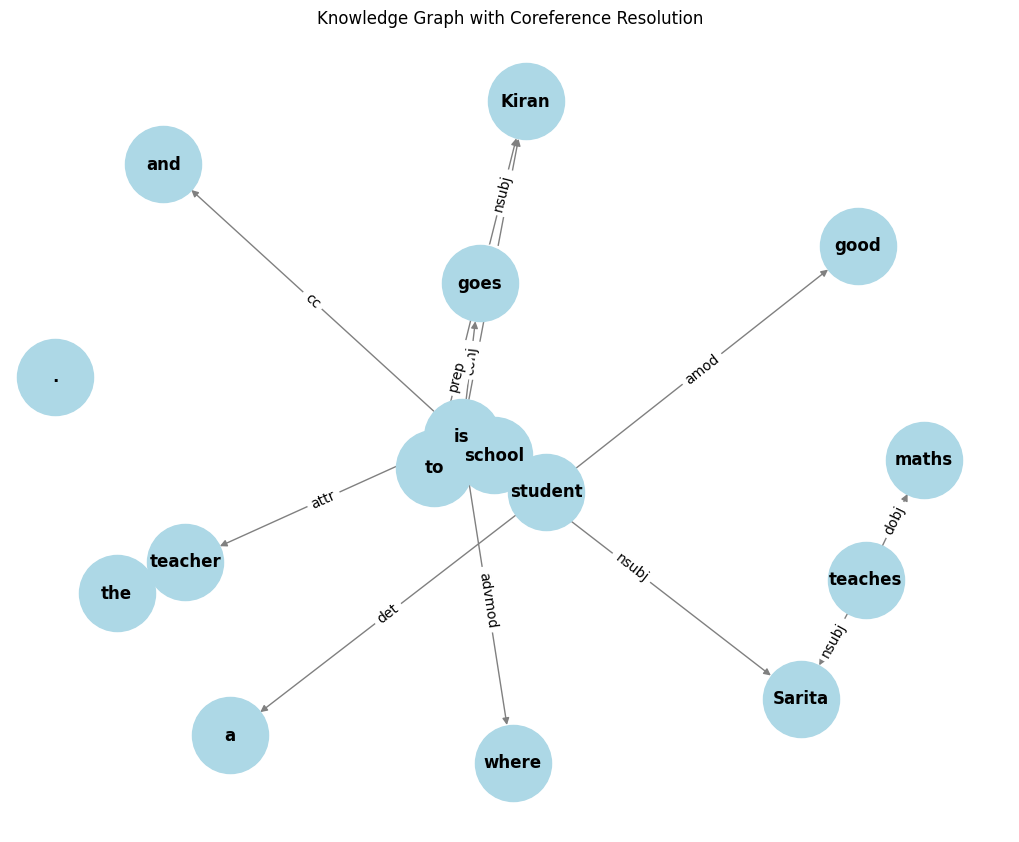

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualize the Knowledge Graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # for consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold', edge_color='gray')
labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Knowledge Graph with Coreference Resolution")
plt.show()


In [ ]:
import spacy
import networkx as nx
from fastcoref import FCoref

# Initialize the coreference model
coref_model = FCoref()

# Define the sample sentence
sentence = "Kiran is a good student and he goes to school where Krishna is the teacher. She teaches maths."
# Predict coreference resolution for the sentence
preds = coref_model.predict(texts=[sentence])

# Retrieve the coreference clusters from the prediction
clusters = preds[0].get_clusters()

# Create a mapping for the coreference clusters
coref_mapping = {}
for cluster in clusters:
    for mention in cluster:
        coref_mapping[mention] = cluster[0]  # Map all mentions to the first mention in the cluster

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Process the sentence with spaCy
doc = nlp(sentence)

# Create a directed graph for the Knowledge Graph
G = nx.DiGraph()

# Add nodes and edges based on dependencies and coreference resolution
for token in doc:
    # Replace mentions in the sentence with their coreference heads
    if token.text in coref_mapping:
        token_text = coref_mapping[token.text]
    else:
        token_text = token.text

    # Add entities to graph as nodes
    G.add_node(token_text)

    if token.dep_ != 'punct' and token.head != token:
        # Add edges based on dependency relations
        if coref_mapping.get(token.head.text, token.head.text) != token_text:  # Prevent self-loop
            G.add_edge(coref_mapping.get(token.head.text, token.head.text), token_text, relation=token.dep_)

# Print the Knowledge Graph in text format
print("Knowledge Graph:")
for u, v, data in G.edges(data=True):
    print(f"{u} --[{data['relation']}]--> {v}")


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Knowledge Graph:
is --[nsubj]--> Kiran
is --[attr]--> student
is --[cc]--> and
is --[conj]--> goes
is --[advmod]--> where
is --[nsubj]--> Krishna
is --[attr]--> teacher
student --[det]--> a
student --[amod]--> good
goes --[nsubj]--> Kiran
goes --[prep]--> to
to --[pobj]--> school
school --[relcl]--> is
teacher --[det]--> the
teaches --[nsubj]--> Krishna
teaches --[dobj]--> maths


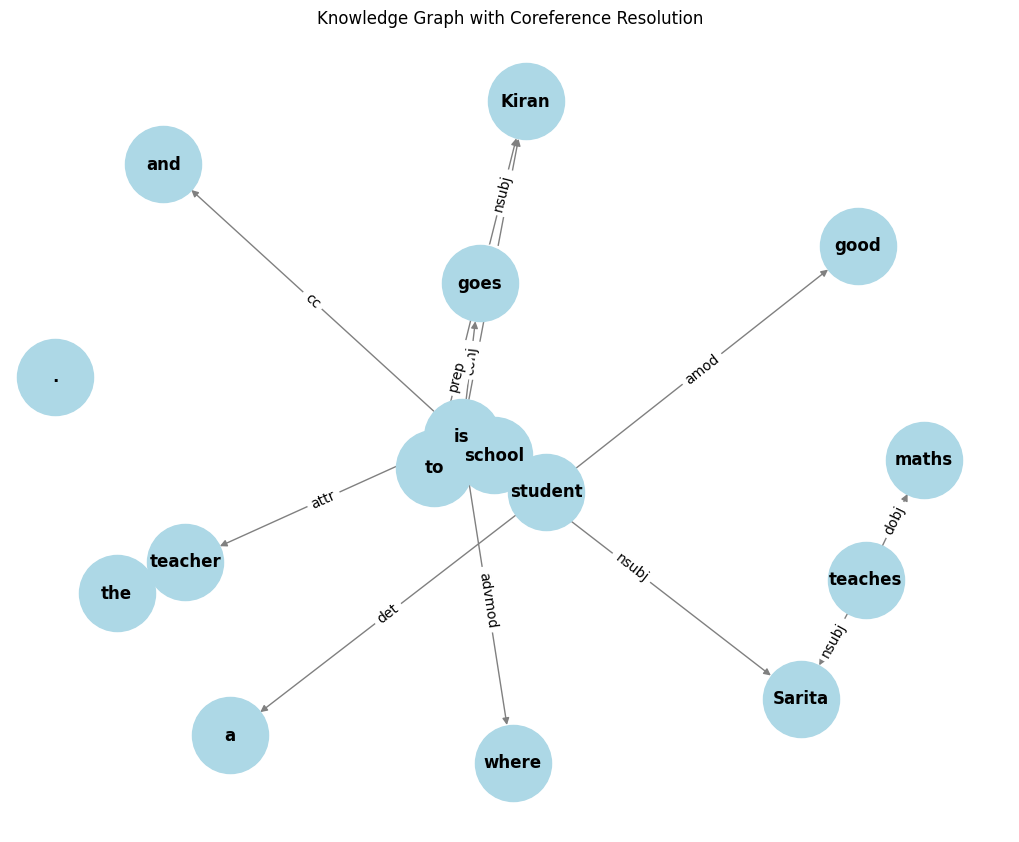

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualize the Knowledge Graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # for consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold', edge_color='gray')
labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Knowledge Graph with Coreference Resolution")
plt.show()
